In [2]:
from sklearn import datasets
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from mpl_toolkits import mplot3d
import numpy as np
import time        
import copy
from sklearn.decomposition import PCA
#from sklearn.preprocessing import StandardScale
from mpl_toolkits.mplot3d import Axes3D

In [3]:
#load data
crix = pd.read_csv('crix-2.csv')
vcrix = pd.read_csv('vcrix-2.csv')

In [4]:
datev = vcrix['date']
v = vcrix['vcrix']
datec = crix['date']
c = crix['price']
crix_pd = pd.concat([datec, c], axis=1)
vcrix_pd= pd.concat([datev, v], axis=1)
crix_pd.set_index(['date','price'])
crix1 = crix_pd.loc[crix_pd['date'] >= '2014-11-28']
crix2 = crix1.reset_index(drop=True)
cvc_new = pd.concat([crix2, v], axis=1)
cvc = cvc_new.drop([1800,1801])
cvc_X = cvc.drop(['date'],axis =1)

In [5]:
cvc1 = cvc.loc[cvc['date'] >= '2017-01-02']
cvc2 = cvc1.reset_index(drop=True)
cvc_X1 = cvc2.drop(['date'],axis =1)

In [6]:
log_p = np.log(cvc['price'])
crix_r = np.diff(log_p)
crix_ret = pd.DataFrame({'log_ret': crix_r[:]})
dd = cvc['date'].drop([0],axis =0)
dd1 = dd.reset_index(drop=True)
v1 = cvc['vcrix'].drop([0], axis =0)
v2 = v1/(np.std(v1))
v2 = v2.reset_index(drop=True)
crc = pd.concat([dd1,crix_ret, v2], axis=1)
crc_X = crc.drop(['date'],axis =1)

In [7]:
cvc2.head()

,date,price,vcrix
0,2017-01-02,1777.585922,414.180445
1,2017-01-03,1815.817644,412.343105
2,2017-01-04,1987.193120,411.799455
3,2017-01-05,1751.581785,505.937128
4,2017-01-06,1593.464083,904.132860


In [8]:
cvc2.to_csv('cvc.csv')

In [15]:
from sklearn.preprocessing import StandardScaler
#standardize the data
Std_cvc = StandardScaler().fit_transform(cvc_X1)
#Std_cvc1= pd.read_csv('Scal_cvc.csv')
#Std_cvc2 = pd.concat([Std_cvc1['x1'], Std_cvc1['x2']], axis=1)
Std_cvc = np.array(Std_cvc)

k = 3
C_e, clusters_e, tau_e= k_expectile_vtau_c(Std_cvc,k)

In [16]:
kmeans = KMeans(n_clusters=k)
kmeans.fit(Std_cvc)
clusters_m = kmeans.labels_
C_m = kmeans.cluster_centers_

In [17]:
from sklearn.cluster import SpectralClustering
spectral = SpectralClustering(n_clusters=k)
spectral.fit(Std_cvc)
clusters_s = spectral.labels_

In [18]:
#matching cluster index
import itertools
def cluster_index(clusters, target, k):
    list_p = list(range(0,k,1))
    permu = list(itertools.permutations(list_p,k))
    new = np.zeros(clusters.shape)
    acc = np.zeros(len(permu))
    for i in range(len(permu)):
        for j in range(0,k,1):
            new[np.where(clusters == j)] = permu[i][j]
        acc[i] = np.sum(new == target)/len(target)
    index = permu[np.argmax(acc)]
    #print(index)
    return index, np.max(acc)

In [19]:
#clusters_q = C_q-1
index1,acc1 = cluster_index(clusters_e,clusters_m,k)
new1 = np.zeros(len(clusters_e))
for j in range(k):
    new1[np.where(clusters_e == j)] = index1[j]

index2,acc2 = cluster_index(clusters_s,clusters_m,k)
new2 = np.zeros(len(clusters_s))
for j in range(k):
    new2[np.where(clusters_s == j)] = index2[j]

In [20]:
new1,clusters_m,acc1
new2,clusters_m,acc2

(array([0., 0., 0., ..., 2., 2., 2.]),
 array([0, 0, 0, ..., 2, 2, 2], dtype=int32),
 0.8644859813084113)

In [23]:
df1= pd.DataFrame(new1, columns=['k-expectiles']) 
df2 = pd.DataFrame(clusters_m, columns=['k-means'])
df3 = pd.DataFrame(new2, columns=['spectral clustering'])
cvc_clusters= pd.concat([cvc2,df1,df2,df3],axis=1)
#cvc_clusters.to_csv('cvc_clusters.csv')

In [72]:
cvc_clusters.head()
#cvc_clusters.to_csv('cvc_clusters2.csv')

,date,price,vcrix,k-expectiles,k-means,spectral clustering
0,2017-01-02,-1.489521,-1.343573,2.0,2,2.0
1,2017-01-03,-1.485757,-1.348718,2.0,2,2.0
2,2017-01-04,-1.468888,-1.350241,2.0,2,2.0
3,2017-01-05,-1.492081,-1.086616,2.0,2,2.0
4,2017-01-06,-1.507645,0.028499,0.0,0,2.0


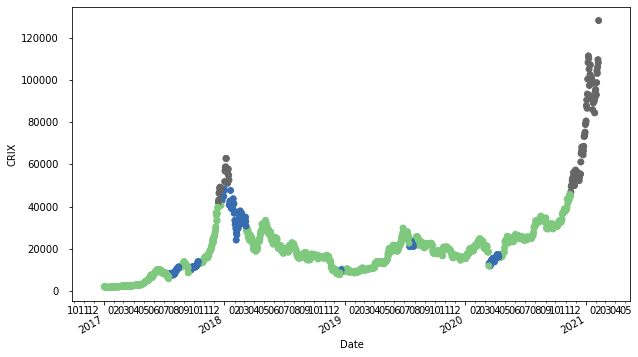

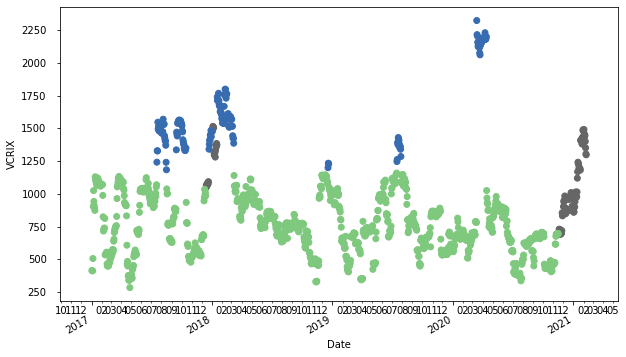

In [15]:
import matplotlib.pyplot as plt
#matplotlib.use('TkAgg')
import matplotlib.dates as mdates
from matplotlib.collections import LineCollection
from matplotlib import rc

# read data
df = cvc1
df = df.iloc[::-1]
df.index = pd.to_datetime(df.date, yearfirst=True)

year = mdates.YearLocator()
month = mdates.MonthLocator()

fig, ax = plt.subplots(figsize = (10,6))
ax.scatter(df.index, df.price.values, c=new1[::-1], cmap=plt.get_cmap('Accent'))
mafmt = mdates.DateFormatter("%Y")
ax.xaxis.set_major_locator(year)
ax.xaxis.set_major_formatter(mafmt)

mifmt = mdates.DateFormatter("%m")
ax.xaxis.set_minor_locator(month)
ax.xaxis.set_minor_formatter(mifmt)
fig.autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('CRIX')
ax.tick_params(pad=10)
#plt.savefig('crix4-kexpectile.png',transparent=True)


fig, ax = plt.subplots(figsize = (10,6))
ax.scatter(df.index, df.vcrix.values, c=new1[::-1], cmap=plt.get_cmap('Accent'))
mafmt = mdates.DateFormatter("%Y")
ax.xaxis.set_major_locator(year)
ax.xaxis.set_major_formatter(mafmt)

mifmt = mdates.DateFormatter("%m")
ax.xaxis.set_minor_locator(month)
ax.xaxis.set_minor_formatter(mifmt)
fig.autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('VCRIX')
ax.tick_params(pad=10)
#plt.savefig('vcrix4-kexpectile.png',transparent=True)

#plt.rcParams['figure.figsize'] = (16, 9)
#plt.scatter(df.iloc[:,1], df.iloc[:,2], c= clusters_c1)
#plt.scatter(C_c1[:,0], C_c1[:,1],marker='*', s=200, c='#050505')
#plt.savefig('two0.6.png',transparent=True)



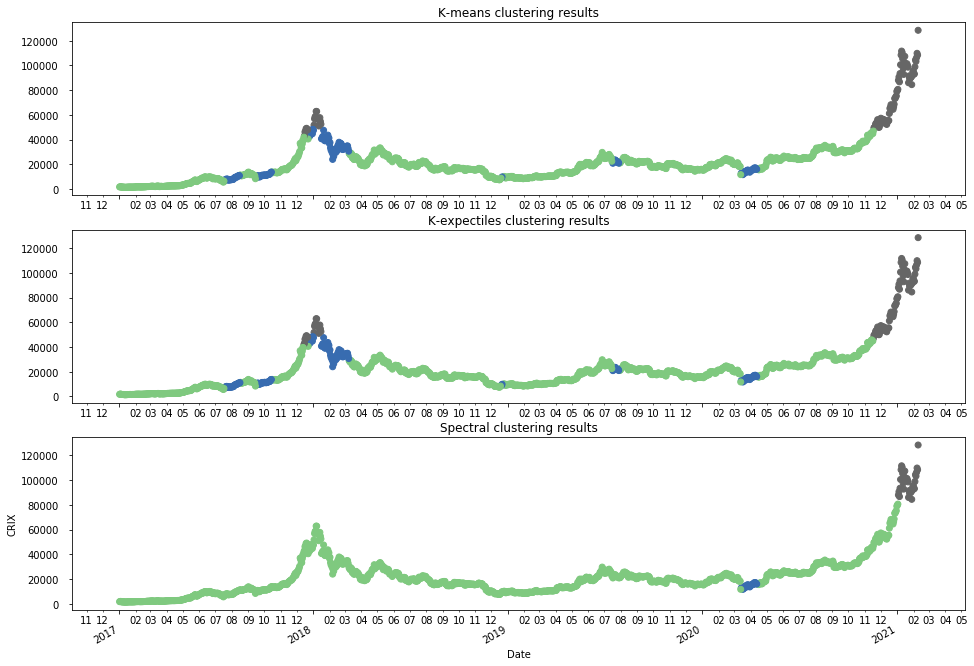

In [16]:
plt.rcParams['figure.figsize'] = (16, 12)
fig, ax = plt.subplots(3,1)
axes = ax.flatten()
axes[0].scatter(df.index, df.price.values, c=clusters_m[::-1], cmap=plt.get_cmap('Accent'))
axes[0].set_title('K-means clustering results')
mafmt = mdates.DateFormatter("%Y")
axes[0].xaxis.set_major_locator(year)
axes[0].xaxis.set_major_formatter(mafmt)

mifmt = mdates.DateFormatter("%m")
axes[0].xaxis.set_minor_locator(month)
axes[0].xaxis.set_minor_formatter(mifmt)
fig.autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('CRIX')
axes[0].tick_params(pad=10)

#fig, ax = plt.subplots(figsize = (16,9))
#fig, ax = plt.subplots(3,1)
axes[1].scatter(df.index, df.price.values, c=new1[::-1], cmap=plt.get_cmap('Accent'))
axes[1].set_title('K-expectiles clustering results')
mafmt = mdates.DateFormatter("%Y")
axes[1].xaxis.set_major_locator(year)
axes[1].xaxis.set_major_formatter(mafmt)

mifmt = mdates.DateFormatter("%m")
axes[1].xaxis.set_minor_locator(month)
axes[1].xaxis.set_minor_formatter(mifmt)
fig.autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('CRIX')
axes[1].tick_params(pad=10)

#fig, ax = plt.subplots(figsize = (16,9))
#fig, ax = plt.subplots(3,1)
axes[2].scatter(df.index, df.price.values, c=new2[::-1], cmap=plt.get_cmap('Accent'))
axes[2].set_title('Spectral clustering results')
mafmt = mdates.DateFormatter("%Y")
axes[2].xaxis.set_major_locator(year)
axes[2].xaxis.set_major_formatter(mafmt)

mifmt = mdates.DateFormatter("%m")
axes[2].xaxis.set_minor_locator(month)
axes[2].xaxis.set_minor_formatter(mifmt)
fig.autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('CRIX')
axes[2].tick_params(pad=10)
#plt.savefig('crix3-compare.png',transparent=True)

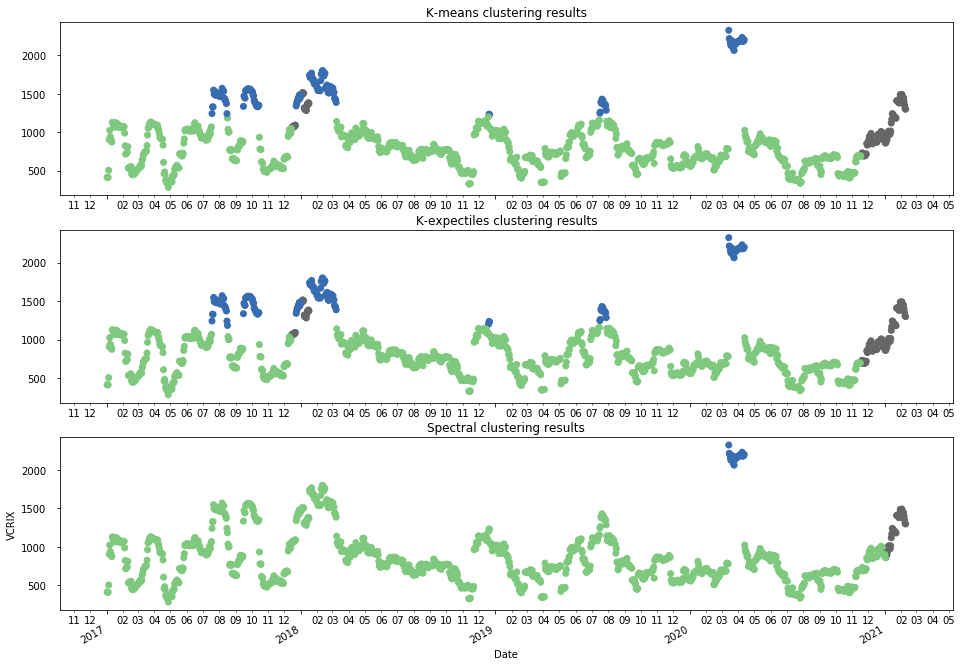

In [41]:
plt.rcParams['figure.figsize'] = (16, 12)
fig, ax = plt.subplots(3,1)
axes = ax.flatten()
axes[0].scatter(df.index, df.vcrix.values, c=clusters_m[::-1], cmap=plt.get_cmap('Accent'))
axes[0].set_title('K-means clustering results')
mafmt = mdates.DateFormatter("%Y")
axes[0].xaxis.set_major_locator(year)
axes[0].xaxis.set_major_formatter(mafmt)

mifmt = mdates.DateFormatter("%m")
axes[0].xaxis.set_minor_locator(month)
axes[0].xaxis.set_minor_formatter(mifmt)
fig.autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('VCRIX')
axes[0].tick_params(pad=10)

#fig, ax = plt.subplots(figsize = (16,9))
#fig, ax = plt.subplots(3,1)
axes[1].scatter(df.index, df.vcrix.values, c=new1[::-1], cmap=plt.get_cmap('Accent'))
axes[1].set_title('K-expectiles clustering results')
mafmt = mdates.DateFormatter("%Y")
axes[1].xaxis.set_major_locator(year)
axes[1].xaxis.set_major_formatter(mafmt)

mifmt = mdates.DateFormatter("%m")
axes[1].xaxis.set_minor_locator(month)
axes[1].xaxis.set_minor_formatter(mifmt)
fig.autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('VCRIX')
axes[1].tick_params(pad=10)

#fig, ax = plt.subplots(figsize = (16,9))
#fig, ax = plt.subplots(3,1)
axes[2].scatter(df.index, df.vcrix.values, c=new2[::-1], cmap=plt.get_cmap('Accent'))
axes[2].set_title('Spectral clustering results')
mafmt = mdates.DateFormatter("%Y")
axes[2].xaxis.set_major_locator(year)
axes[2].xaxis.set_major_formatter(mafmt)

mifmt = mdates.DateFormatter("%m")
axes[2].xaxis.set_minor_locator(month)
axes[2].xaxis.set_minor_formatter(mifmt)
fig.autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('VCRIX')
axes[2].tick_params(pad=10)
plt.savefig('vcrix3-compare.png',transparent=True)

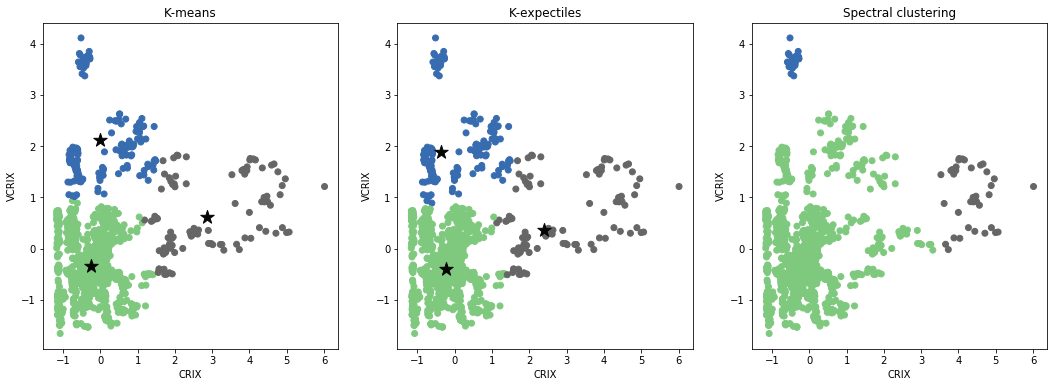

In [40]:
plt.rcParams['figure.figsize'] = (18,6)
plt.subplot(131)
#plt.scatter( df.price.values, df.vcrix.values,c= clusters2, cmap=plt.get_cmap('Set1'))
plt.scatter( Std_cvc[:,0], Std_cvc[:,1],c= clusters_m, cmap=plt.get_cmap('Accent'))
plt.scatter(C_m[:,0], C_m[:,1],marker='*', s=200, c='#050505')
plt.xlabel('CRIX')
plt.ylabel('VCRIX')
plt.title('K-means')


plt.subplot(132)
plt.scatter( Std_cvc[:,0], Std_cvc[:,1],c= new1, cmap=plt.get_cmap('Accent'))
plt.scatter(C_e[:,0], C_e[:,1],marker='*', s=200, c='#050505')
plt.xlabel('CRIX')
plt.ylabel('VCRIX')
plt.title('K-expectiles')


plt.subplot(133) 
plt.scatter( Std_cvc[:,0], Std_cvc[:,1],c= new2, cmap=plt.get_cmap('Accent'))
plt.xlabel('CRIX')
plt.ylabel('VCRIX')
plt.title('Spectral clustering')
plt.savefig('data_view3.png',transparent=True)

In [20]:
from sklearn import metrics
s1 = metrics.silhouette_score(Std_cvc, clusters_m, metric='euclidean')
s2 = metrics.silhouette_score(Std_cvc, clusters_e, metric='euclidean')
s3 = metrics.silhouette_score(Std_cvc, clusters_s, metric='euclidean')
c1 = metrics.calinski_harabasz_score(Std_cvc, clusters_m)
c2 = metrics.calinski_harabasz_score(Std_cvc, clusters_e)
c3 = metrics.calinski_harabasz_score(Std_cvc, clusters_s)
d1 = metrics.davies_bouldin_score(Std_cvc, clusters_m)
d2 = metrics.davies_bouldin_score(Std_cvc, clusters_e)
d3 = metrics.davies_bouldin_score(Std_cvc, clusters_s)
#s1,s2
#c1,c2

In [21]:
d1,d2,d3

(0.7046702383358472, 0.7101729912897857, 0.32385280019540863)

In [127]:
from sklearn import metrics
DB =  list()
silhouette =  list()
for k in range(2,15):
    C_c1, clusters1,tau1 = k_expectile_vtau_c(Std_cvc,k)
    s1 = metrics.silhouette_score(Std_cvc, clusters1, metric='euclidean')
    print(s1)
    s2 = metrics.davies_bouldin_score(Std_cvc, clusters1)
    print(s2)
    DB.append(s2)
    silhouette.append(s1)

0.5952040502287912
0.9433524841246447
0.5768124340458662
0.7101729912897857
0.36389675079415096
0.9242140602329915
0.3737917853570344
0.8314477467657193
0.34730600364869746
0.8446498298204022
0.4095068426478063
0.7363245771747573
0.4225145717940758
0.7153950368438428
0.44351247691019396
0.6352235957822299
0.4536522765339015
0.6271189434762878
0.4541848765871714
0.6559553441496266
0.4555514953116581
0.66437142958171
0.43082049669878864
0.6733068176330838
0.43283598386466393
0.6798727129850606


Text(0, 0.5, 'DB_score')

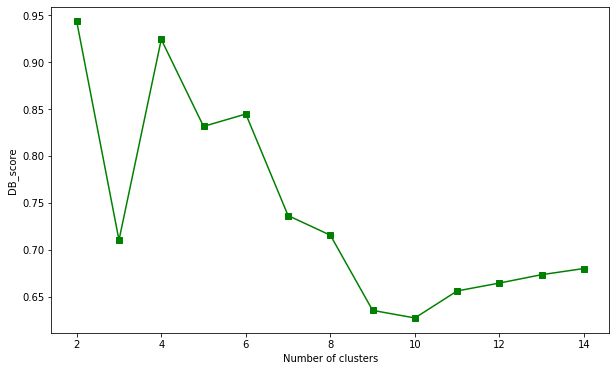

In [129]:
fig, ax = plt.subplots(figsize = (10,6))
plt.plot(range(2,15), DB,'g-s')
plt.xlabel('Number of clusters')
plt.ylabel('DB_score')
#plt.savefig('calinski.png',transparent=True)

In [193]:
def tau_var(points, tau, mu):
    res = points - mu
    neg = np.array([res<0],dtype=np.int32)
    pos = np.array([res>=0],dtype=np.int32)
    w_pos = pos * tau
    w_neg = neg * (1-tau)
    dist = (res ** 2 * w_pos).sum(axis = res.ndim) + (res ** 2 * w_neg).sum(axis = res.ndim)
    var = dist.sum(axis = dist.ndim-1)
    return var

def cal_W(x, clusters, centroid, tau, k):
    g_var = 0
    for d in range(k):
        points = [x[i] for i in range(len(x)) if clusters[i] == d]
        var = tau_var(points, tau[d], centroid[d])
        g_var = g_var + var
    return g_var

In [196]:
W =  list()
for j in range(1,12):
    C1, clusters1, tau1 = k_expectile_vtau_c(Std_cvc,j)
    w = cal_W(Std_cvc, clusters1, C1, tau1, j)
    #print(w)
    W.append(float(w))

In [149]:
p = len(Std_cvc[1])
KL =  list()
for k in range(1,10):
    diff_k = (k)**(p/2)*W[k-1]-(k+1)**(p/2)*W[k]
    diff_k1 = (k+1)**(p/2)*W[k]-(k+2)**(p/2)*W[k+1]
    kl = abs(diff_k/diff_k1)
    print(kl)
    KL.append(kl)

3.0139458360302727
1.0834251131485273
2.5475785217349176
1.6857243562364703
0.1950742372214905
1.4663480413156735
0.7243315637679224
2.0627503255364132
0.9453159633429495


In [155]:
n = len(Std_cvc)
H =  list()
for k in range(1,10):
    h = (W[k-1]/W[k]-1)/(n-k-2)
    print(h)
    H.append(h)

0.0003019191998804563
0.00043520275817114575
0.00031420363770008993
0.0001353595670629872
0.00015291655959597455
0.00021823161598493625
3.086014792809764e-05
0.0001842459046016018
0.0001260486432778394


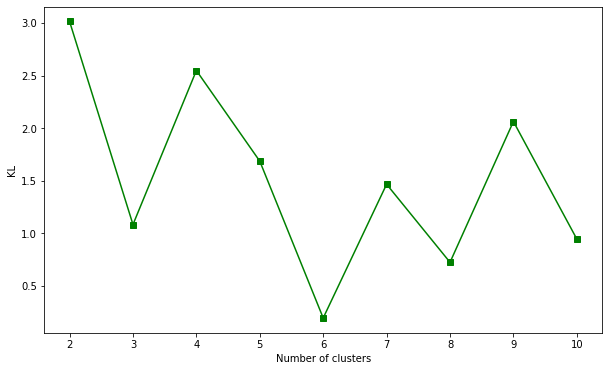

In [152]:
fig, ax = plt.subplots(figsize = (10,6))
plt.plot(range(2,11), KL,'g-s')
plt.xlabel('Number of clusters')
plt.ylabel('KL')
plt.savefig('KL_score.png',transparent=True)

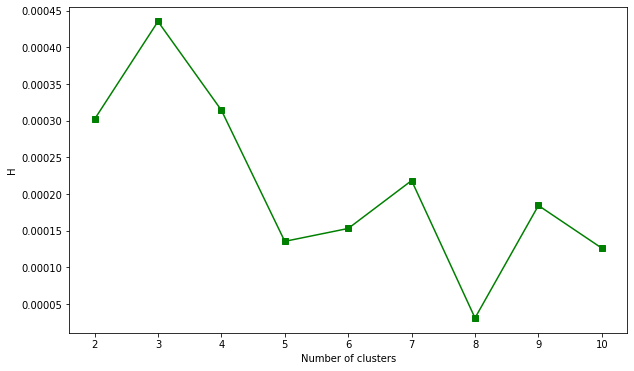

In [156]:
fig, ax = plt.subplots(figsize = (10,6))
plt.plot(range(2,11), H,'g-s')
plt.xlabel('Number of clusters')
plt.ylabel('H')
plt.savefig('H_score.png',transparent=True)

In [1]:
#Euclidean distance
def dist(a, b):
    return np.linalg.norm(a - b, None)
#Tau-distance
def tau_dist_fun(x, centroid, tau):
    arr = x - centroid
    tau_ar = tau[None:,:]
    neg = np.array([arr<0],dtype=np.int32)
    pos = np.array([arr>=0],dtype=np.int32)
    w_pos = pos * tau_ar
    w_neg = neg * (1-tau_ar)
    dist = (arr ** 2 * w_pos).sum(axis = arr.ndim) + (arr ** 2 * w_neg).sum(axis = arr.ndim)
    return dist
#get centroids
def get_closest_centroid(x, centroid, tau):
    # Loop over each centroid and compute the distance from data point.
    dist = tau_dist_fun(x, centroid, tau)
    # Get the index of the centroid with the smallest distance to the data point
    assigned_centroids = np.argmin(dist, axis = 2)
    clusters = np.squeeze(assigned_centroids)
    return clusters
#Expectile estimation
def expectile_fun_c(group, tau):
    e = np.mean(group, axis=0)
    e_new = np.zeros(e.shape)
    while dist(e_new , e) != 0:
        res = group - e
        e = copy.deepcopy(e_new)
        neg = np.array([res<0],dtype = np.int32)
        pos = np.array([res>=0],dtype= np.int32)
        norm = pos.sum(axis=1)*tau + neg.sum(axis=1)*(1-tau)
        e_arr = (tau * (group * pos).sum(axis=1) + (1-tau) * (group * neg).sum(axis=1))/norm
        e_new = np.squeeze(e_arr)
    return e_new
#Estimate optimal taus
def tau_fun_c(group, e):
    res = group - e
    neg = np.array([res<0],dtype = np.int32)
    pos = np.array([res>=0],dtype= np.int32)
    neg_s = -(neg*res).sum(axis=1)/neg.sum(axis=1)
    pos_s = (pos*res).sum(axis=1)/pos.sum(axis=1)
    c = neg_s/pos_s
    tau = c/(1+c)
    return tau
# Define K expectile clustering 
# Main function
def k_expectile_vtau_c(X, k):
    X = np.array(X)
# Initialize cluster centers as K means cluster centers
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    C = kmeans.cluster_centers_

# To store the value of centroids when it updates
    C_old = np.zeros(C.shape)
# Initialize tau = 0.5
    tau = np.ones(C.shape)*0.5
# Error func. - Distance between new centroids and old centroids
    error = dist(C, C_old)
# main loop    
    for r in range(30):
        # Get closest centroids to each data point
        assigned_clusters = get_closest_centroid(X[:, None, :], C[None,:, :], tau)
        # Storing the old centroid values
        C_old = copy.deepcopy(C)
        # Compute new centroids
        for c in range(k):
            # Get data points belonging to each cluster 
            cluster_members = X[assigned_clusters == c]
        
            # Compute the centroids of the clusters
            C[c] = expectile_fun_c(cluster_members, tau[c])
        
            # Update the tau
            tau[c] = tau_fun_c(cluster_members, C[c])
        error = dist(C, C_old)
        #print(error)
    return C, assigned_clusters, tau